import

In [1]:
import cv2
import base64
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.stats import qmc, rankdata, t as t_dist

from IPython.display import HTML, display
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter

from google.colab import files
from google.colab import output
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Common Function

In [ ]:
def solve_segment(f_ivp, state, t_eval, rtol=1e-6, atol=1e-9, method="RK45"):
    sol = solve_ivp(
        f_ivp,
        (float(t_eval[0]), float(t_eval[-1])),
        np.array(state, dtype=float),
        t_eval=np.array(t_eval, dtype=float),
        rtol=rtol,
        atol=atol,
        method=method,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol.y.T


In [ ]:
def happen_event(solution, event_id):
    event_list = [
        [[solution[-1, 0], solution[-1, 1]]],          # 0: identity
        [[1, 0]],                                      # 1: B=1, MA=0
        [[solution[-1, 0]*0.5, solution[-1, 1]*0.5]],  # 2: B*0.5, MA*0.5
        [[solution[-1, 0], 0]],                        # 3: MA = 0
        [[solution[-1, 0], solution[-1, 1]*0.5]],      # 4: MA*0.5
        [[1, solution[-1, 1]]],                        # 5: B = 1
        [[solution[-1, 0]*0.5, solution[-1, 1]]]       # 6: B*0.5
    ]
    return event_list[event_id]

In [ ]:
def simulate_with_events(
    f_ivp, state0, t_within_event, event_ids,
    rtol=1e-6, atol=1e-9, method="RK45",
):
    """
    For each event_id:
      1) integrate over local time grid t_within_event (0..Tevent)
      2) apply happen_event to the final point, overwrite sol[-1]
      3) concatenate trajectory
    """
    state = np.array(state0, dtype=float)
    time_evolution = np.empty((0, 2), dtype=float)

    for eid in event_ids:
        sol = solve_segment(f_ivp, state, t_within_event, rtol=rtol, atol=atol, method=method)

        event_state = np.array(happen_event(sol, eid)[0], dtype=float)
        sol[-1] = event_state

        time_evolution = np.append(time_evolution, sol, axis=0)
        state = sol[-1]

    return time_evolution, state

Model

In [ ]:
def make_system_ivp(params):
    r, a, b, p, q = params["r"], params["a"], params["b"], params["p"], params["q"]

    def f(t, y):
        B, MA = y
        K = a * (1 - MA) + b * MA
        dBdt = r * B * (1 - B / K)
        dMAdt = -q * MA + p * (B/K) * (1 - MA)
        return np.array([dBdt, dMAdt], dtype=float)

    return f

In [ ]:
params_base = { 'r' : 1.31,
                'a' : 390,
                'b' : 1025,
                'p' : 0.030,
                'q' : 0.032 }

f_ivp_base = make_system_ivp(params_base)

Time evolution

In [ ]:
initial_state = [1.0, 0.0]
t = np.linspace(0, 200, 2000)
solution = solve_segment(f_ivp_base, initial_state, t)

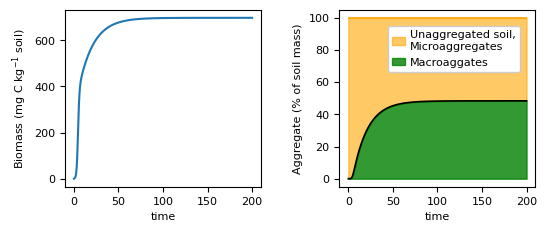

In [ ]:
# Figure setting
plt.rcParams['font.size'] = 8
mm_to_inch = 1 / 25.4
fig_w_mm = 140
fig_h_mm = 60
figsize_inch = (fig_w_mm * mm_to_inch, fig_h_mm * mm_to_inch)
fig, axes = plt.subplots(1, 2, figsize=figsize_inch, sharex=True)

# Data
biomass = solution[:, 0]
macro_frac = solution[:, 1]
macro = macro_frac * 100
micro = 100-macro

# Plot
axes[0].plot(t, biomass)
axes[0].set_xlabel('time')
axes[0].set_ylabel(r'Biomass (mg C kg$^{-1}$ soil)')

axes[1].hlines(y=100, xmin=0, xmax=max(t), color='orange',linewidth=1.2)
axes[1].fill_between(t, macro, 100, color='orange', alpha=0.6, label='Unaggregated soil,\nMicroaggregates')
axes[1].fill_between(t, 0, macro, alpha=0.8, color='green' ,label='Macroaggates')
axes[1].plot(t, macro, color='black',linewidth=1.2)
axes[1].set_xlabel('time')
axes[1].set_ylabel('Aggregate (% of soil mass)')
axes[1].legend(frameon=True, loc='center right', bbox_to_anchor=(0.95, 0.78),handlelength=1.2, handletextpad=0.4,framealpha=1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/time_evolution_2panels.png',dpi=300)
plt.show()

Disturbance (base parameter set)

In [ ]:
event_num = 2
t_within_event_disturbance = np.linspace(0, 100, 1000)
state0 = [1.0, 0.0]

event_ids = [0] * event_num
time_evolution_event0, final_state_event0 = simulate_with_events(
    f_ivp_base, state0, t_within_event_disturbance, event_ids
)

event_ids = [3] * event_num
time_evolution_event3, final_state_event3 = simulate_with_events(
    f_ivp_base, state0, t_within_event_disturbance, event_ids
)

event_ids = [5] * event_num
time_evolution_event5, final_state_event5 = simulate_with_events(
    f_ivp_base, state0, t_within_event_disturbance, event_ids
)

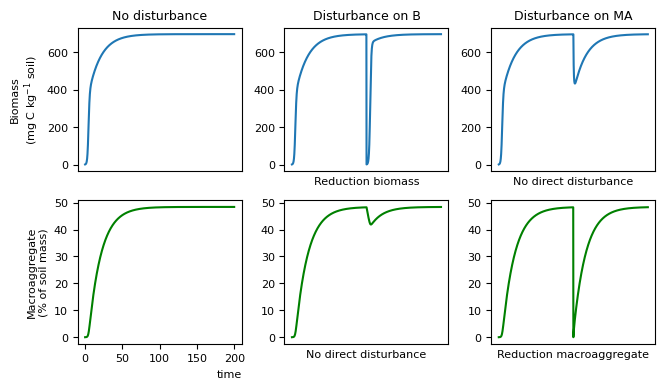

In [ ]:
# Figure settings
mm_to_inch = 1 / 25.4
fig_w_mm, fig_h_mm = 170, 100
figsize_inch = (fig_w_mm * mm_to_inch, fig_h_mm * mm_to_inch)
plt.rcParams["font.size"] = 8

# Data
datasets = {
    0: time_evolution_event0,
    5: time_evolution_event5,
    3: time_evolution_event3,
}

event_order = [0, 5, 3]

titles = {
    0: "No disturbance",
    5: "Disturbance on B",
    3: "Disturbance on MA",
}

# plot
time = np.arange(len(time_evolution_event0)) / 10.0
tick_positions = np.linspace(time.min(), time.max(), 5)
tick_labels = [str(int(v)) for v in np.linspace(0, 200, 5)]

b_all = np.concatenate([datasets[e][:, 0] for e in event_order])
b_min, b_max = b_all.min(), b_all.max()
b_margin = 0.05 * (b_max - b_min)

ma_all = np.concatenate([datasets[e][:, 1] for e in event_order]) * 100
ma_min, ma_max = ma_all.min(), ma_all.max()
ma_margin = 0.05 * (ma_max - ma_min)


fig, axes = plt.subplots(2, 3, figsize=figsize_inch, sharex=False)
for col, ev in enumerate(event_order):
    data = datasets[ev]
    biomass = data[:, 0]
    macro_pct = data[:, 1] * 100

    # ---- Row 0: Biomass ----
    ax0 = axes[0, col]
    ax0.plot(time[:-1], biomass[:-1])

    ax0.set_title(titles[ev], fontsize=9)
    ax0.set_ylim(b_min - b_margin, b_max + b_margin)
    ax0.set_xticks([])

    if col == 0:
        ax0.set_ylabel("Biomass\n(mg C kg$^{-1}$ soil)")

    # ---- Row 1: Macroaggregate ----
    ax1 = axes[1, col]
    ax1.plot(time[:-1], macro_pct[:-1], color="green")

    ax1.set_ylim(ma_min - ma_margin, ma_max + ma_margin)
    ax1.set_xlabel("time")

    if col == 0:
        ax1.set_ylabel("Macroaggregate\n(% of soil mass)")
        ax1.set_xticks(tick_positions)
        ax1.set_xticklabels(tick_labels)
        ax1.set_xlabel("time", loc="right")
    else:
        ax1.set_xticks([])
        ax1.set_xlabel("")

axes[0, 1].set_xlabel("Reduction biomass")
axes[0, 2].set_xlabel("No direct disturbance")
axes[1, 1].set_xlabel("No direct disturbance")
axes[1, 2].set_xlabel("Reduction macroaggregate")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Fractal Interaction/Save/fig/timeevo_single_disturbance.png",dpi=300)
plt.show()

In [ ]:
event_num = 10
t_within_event_periodic = np.linspace(0, 29, 290)
state0 = [1.0, 0.0]

event_ids = [0] * event_num
time_evolution_event0, final_state_event0 = simulate_with_events(f_ivp_base, state0, t_within_event_periodic, event_ids)

event_ids = [3] * event_num
time_evolution_event3, final_state_event3 = simulate_with_events(f_ivp_base, state0, t_within_event_periodic, event_ids)

event_ids = [5] * event_num
time_evolution_event5, final_state_event5 = simulate_with_events(f_ivp_base, state0, t_within_event_periodic, event_ids)

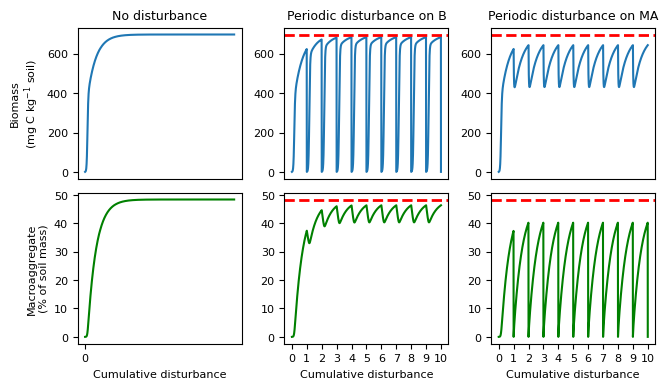

In [ ]:
# Figure settings
mm_to_inch = 1 / 25.4
fig_w_mm, fig_h_mm = 170, 100
figsize_inch = (fig_w_mm * mm_to_inch, fig_h_mm * mm_to_inch)
plt.rcParams["font.size"] = 8

# Data
datasets = {
    0: time_evolution_event0,
    3: time_evolution_event3,
    5: time_evolution_event5,
}
event_order = [0, 5, 3]

titles = {
    0: "No disturbance",
    5: "Periodic disturbance on B",
    3: "Periodic disturbance on MA",
}

steps = np.arange(len(time_evolution_event0)) / 10.0

b0 = time_evolution_event0[:, 0]
ma_frac0 = time_evolution_event0[:, 1]
ma_frac_ref = ma_frac0[-1]
ma_pct_ref = ma_frac_ref * 100
b_total_ref = b0[-1]

# Plot
b_total_all = np.concatenate([datasets[e][:, 0] for e in event_order])
bt_min, bt_max = b_total_all.min(), b_total_all.max()
bt_margin = 0.05 * (bt_max - bt_min) if bt_max > bt_min else 0.0

ma_frac_all = np.concatenate([
    datasets[e][:, 1] for e in event_order
])
ma_pct_all = ma_frac_all * 100
ma_min, ma_max = ma_pct_all.min(), ma_pct_all.max()
ma_margin = 0.05 * (ma_max - ma_min) if ma_max > ma_min else 0.0

# tick_positions = np.linspace(steps.min(), steps.max(), 11)
# tick_labels = [str(int(v)) for v in np.linspace(0, 400, 11)]

simple_xticks = np.linspace(steps.min(), steps.max(), 11) # [steps.min(), (steps.min() + steps.max()) / 2, steps.max()]
simple_xticklabels = [ i for i in range(0,11) ]

fig, axes = plt.subplots(2, 3, figsize=figsize_inch, sharex=False)
for col, ev in enumerate(event_order):
    data = datasets[ev]
    biomass = data[:, 0]
    macro_frac = data[:, 1]
    macro_pct = macro_frac * 100

    # ---- Row 0: Total biomass ----
    ax0 = axes[0, col]
    ax0.plot(steps, biomass)

    if col != 0:
        ax0.axhline(b_total_ref, color="red", linestyle="--", linewidth=2)

    ax0.set_title(titles[ev], fontsize=9)
    ax0.set_ylim(bt_min - bt_margin, bt_max + bt_margin)
    ax0.set_xticks([])

    if col == 0:
        ax0.set_ylabel(
            "Biomass\n(mg C kg$^{-1}$ soil)"
        )

    # ---- Row 1: Macroaggregates (%) ----
    ax1 = axes[1, col]
    ax1.plot(steps, macro_pct, color="green")

    if col != 0:
        ax1.axhline(ma_pct_ref, color="red", linestyle="--", linewidth=2)

    ax1.set_ylim(ma_min - ma_margin, ma_max + ma_margin)

    if col == 0:
        ax1.set_ylabel("Macroaggregate\n(% of soil mass)")
        ax1.set_xticks([0]) # Set x-ticks to only '0'
        ax1.set_xticklabels(['0']) # Set x-tick labels to '0'
        ax1.set_xlabel("Cumulative disturbance") # Change x-label

    else:
        ax1.set_xticks(simple_xticks)
        ax1.set_xticklabels(simple_xticklabels)
        ax1.set_xlabel("Cumulative disturbance")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Fractal Interaction/Save/fig/timeevo_peridic_disturbance.png",dpi=300)
plt.show()

Offset image

In [ ]:
params_offset = { 'r' : 1,
             'a' : 100 ,
             'b' : 1000 ,
             'p' : 0.002 ,
             'q' : 0.002 }

f_ivp_offset = make_system_ivp(params_offset)

In [ ]:
event_num = 20
t_within_event_offset = np.linspace(0, 100, 1000)
state0 = [1.0, 0.0]

event_ids = [0] * event_num
time_evolution_event0, final_state_event0 = simulate_with_events(f_ivp_offset, state0, t_within_event_offset, event_ids)

event_ids = [4] * event_num
time_evolution_event3, final_state_event3 = simulate_with_events(f_ivp_offset, state0, t_within_event_offset, event_ids)

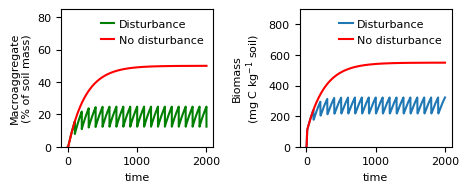

In [ ]:
# Common plotting settings
plt.rcParams['font.size'] = 8
mm_to_inch = 1 / 25.4
fig_w_mm, fig_h_mm = 120, 50
figsize_inch = (fig_w_mm * mm_to_inch, fig_h_mm * mm_to_inch)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=figsize_inch, sharex=True)

# Calculate x-axis steps for plotting
steps_disturbance = np.arange(len(time_evolution_event3)) / 10.0
steps_no_disturbance = np.arange(len(time_evolution_event0)) / 10.0

# --- Plot 1 (LEFT): Secondary Aggregates Evolution (MA) ---
ax1 = axes[0]
ax1.plot(steps_disturbance, time_evolution_event3[:, 1]*100, label='Disturbance', c='green')
ax1.plot(steps_no_disturbance, time_evolution_event0[:, 1]*100, label='No disturbance', c='red')
ax1.set_ylabel('Macroaggregate\n(% of soil mass)')
ax1.set_xlabel('time')
ax1.set_ylim(0, 85)
ax1.legend(frameon=False, loc='upper right', handlelength=1.2, handletextpad=0.4)

# --- Plot 2 (RIGHT): Biomass Evolution (B) ---
ax0 = axes[1]
ax0.plot(steps_disturbance, time_evolution_event3[:, 0], label='Disturbance')
ax0.plot(steps_no_disturbance, time_evolution_event0[:, 0], label='No disturbance', c='red')
ax0.set_ylabel('Biomass\n(mg C kg$^{-1}$ soil)')
ax0.set_ylim(0, 900)
ax0.set_xlabel('time')
ax0.legend(frameon=False, loc='upper right', handlelength=1.2, handletextpad=0.4)

plt.tight_layout()

# Save the combined figure
plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/timeevo_offset_combined.png', dpi=300)
plt.show()

### sensitive analysis for offset

In [ ]:
def estimate_Tconv_noevent(
    f_ivp, state0,
    dt_check=0.5,
    t_max=5000.0,
    tol=1e-3,
    window=5,
    B_scale=None,
    MA_scale=1.0,
    rtol=1e-6, atol=1e-9, method="RK45",
):
    """
    Undisturbed continuous-time dynamics (no events).
    Converged if normalized speed < tol for `window` consecutive check steps.

    normalized speed:
      max( |dB/dt|/(|B|+B_scale), |dMA/dt|/(|MA|+MA_scale) )
    """
    n_steps = int(np.floor(t_max / dt_check))
    t_grid = np.linspace(0.0, n_steps * dt_check, n_steps + 1)

    sol = solve_ivp(
        f_ivp,
        (float(t_grid[0]), float(t_grid[-1])),
        np.array(state0, dtype=float),
        t_eval=t_grid,
        rtol=rtol,
        atol=atol,
        method=method,
    )
    if not sol.success:
        raise RuntimeError(sol.message)

    Y = sol.y.T  # (len(t_grid),2)

    if B_scale is None:
        B_scale = 1.0

    stable = 0
    for k in range(len(t_grid)):
        B, MA = Y[k]
        dBdt, dMAdt = f_ivp(t_grid[k], Y[k])

        crit_B = abs(dBdt) / (abs(B) + B_scale)
        crit_MA = abs(dMAdt) / (abs(MA) + MA_scale)
        crit = max(crit_B, crit_MA)

        if crit < tol:
            stable += 1
            if stable >= window:
                return float(t_grid[k]), Y[k].copy(), True
        else:
            stable = 0

    return float(t_grid[-1]), Y[-1].copy(), False

In [ ]:
def _max_metrics(traj):
    return float(np.max(traj[:, 0])), float(np.max(traj[:, 1]))

In [ ]:
def compute_metrics(
    params, state0,
    n_events,                 # number of events to run for offsets (e.g., 10)
    dt_check=0.5,             # sampling interval for Tconv estimation
    t_max=500.0,              # max time for Tconv estimation
    tol_conv=1e-6,            # convergence threshold for Tconv estimation
    window=5,                 # consecutive hits for Tconv estimation
    eps=1e-12,                # stabilizer for relative offsets
    rtol=1e-6, atol=1e-9, method="RK45",
    disturbance_event_id=3,   # event_id used for disturbance
    Ttime=3.0,                # time scale for Tconv
    make_system_ivp_func=None, # New parameter to pass the system factory function
):
    """
    1) Estimate Tconv from undisturbed continuous-time dynamics (no events)
    2) Define Tevent = Tconv/3
    3) Define n_timepoints = Tevent * 10 (ceil, min 2) and build t_event
    4) Run n_events events for:
       - event0: all 0
       - event3: all disturbance_event_id
    5) Compute max_B/max_MA and relative offsets
    """
    if make_system_ivp_func is None:
        raise ValueError("make_system_ivp_func must be provided for compute_metrics")
    f_ivp = make_system_ivp_func(params)

    # --- Tconv (no event) ---
    B_scale = max(params["a"], params["b"])

    Tconv, _, converged = estimate_Tconv_noevent(
        f_ivp, state0,
        dt_check=dt_check, t_max=t_max,
        tol=tol_conv, window=window,
        B_scale=B_scale, MA_scale=1.0,
        rtol=rtol, atol=atol, method=method
    )

    Tevent = Tconv / Ttime
    if Tevent <= 0:
        raise ValueError("Estimated Tevent <= 0. Check dt_check/t_max/tol_conv/window.")

    # --- event internal grid: n_timepoints = Tevent * 10 ---
    n_timepoints = max(2, int(np.ceil(Tevent * 10.0)))
    t_event = np.linspace(0.0, Tevent, n_timepoints)

    # --- compare event0 vs eventX with equal number of events ---
    event_ids0 = [0] * int(n_events)
    event_ids3 = [disturbance_event_id] * int(n_events)

    tev0, _ = simulate_with_events(f_ivp, state0, t_event, event_ids0, rtol=rtol, atol=atol, method=method)
    tev3, _ = simulate_with_events(f_ivp, state0, t_event, event_ids3, rtol=rtol, atol=atol, method=method)

    B0, MA0 = _max_metrics(tev0)
    B3, MA3 = _max_metrics(tev3)

    return {
        # convergence/time scaling
        "Tconv": float(Tconv),
        "Tevent": float(Tevent),
        "n_timepoints": int(n_timepoints),
        "converged": bool(converged),

        # simulation setup
        "n_events": int(n_events),
        "dt_check": float(dt_check),
        "t_max": float(t_max),
        "tol_conv": float(tol_conv),
        "window": int(window),

        # metrics & offsets
        "max_B_event0": B0,
        "max_B_event3": B3,
        "offset_B": abs(B3 - B0) / (abs(B0) + eps),

        "max_MA_event0": MA0,
        "max_MA_event3": MA3,
        "offset_MA": abs(MA3 - MA0) / (abs(MA0) + eps),
    }

In [ ]:
def sweep_1d_df(param_name, param_list, base_params, state0, **metric_kwargs):
    rows = []
    for val in param_list:
        params = dict(base_params)
        params[param_name] = val
        rows.append({**params, **compute_metrics(params, state0, **metric_kwargs)})
    return pd.DataFrame(rows)

def sweep_2d_df_ab(a_list, b_list, base_params, state0, **metric_kwargs):
    rows = []
    for a in a_list:
        for b in b_list:
            if not (a < b):
                continue

            params = dict(base_params)
            params["a"] = a
            params["b"] = b

            rows.append({
                **params,
                **compute_metrics(params, state0, **metric_kwargs),
            })
    return pd.DataFrame(rows)

def sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs):
    rows = []
    for r in r_list:
        for p in p_list:
            for q in q_list:

                params = dict(base_params)
                params["r"] = r
                params["p"] = p
                params["q"] = q

                rows.append({
                    **params,
                    **compute_metrics(params, state0, **metric_kwargs),
                })

    return pd.DataFrame(rows)

In [ ]:
def _edges(c):
    c = np.asarray(c, float)
    if c.size == 1:
        return np.array([c[0]-0.5, c[0]+0.5])
    d = np.diff(c)
    e = np.empty(c.size + 1)
    e[1:-1] = c[:-1] + d/2
    e[0], e[-1] = c[0]-d[0]/2, c[-1]+d[-1]/2
    return e

def heat(ax, df, x="a", y="b", v="offset_MA", *, vmin=None, vmax=None, cmap="viridis", x_log_scale=True, y_log_scale=True):
    tab = df.pivot_table(index=y, columns=x, values=v, aggfunc="mean")

    xs = np.sort(tab.columns.to_numpy(float))
    ys = np.sort(tab.index.to_numpy(float))
    z  = tab.reindex(index=ys, columns=xs).to_numpy(float)

    Xe, Ye = _edges(xs), _edges(ys)

    # Determine vmin and vmax automatically if not provided
    if vmin is None:
        vmin = np.nanmin(z)
    if vmax is None:
        vmax = np.nanmax(z)

    m = ax.pcolormesh(Xe, Ye, np.ma.masked_invalid(z),
                      shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    if x_log_scale:
        ax.set_xscale("log")
        ax.xaxis.set_major_locator(LogLocator(base=10))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.xaxis.set_minor_formatter(NullFormatter())
    else:
        ax.set_xscale("linear")
        # Allow Matplotlib to automatically set "normal" linear ticks
        # Removed: ax.set_xticks([xs[0], xs[-1]]) and ax.set_xticklabels([f'{xs[0]:.0f}', f'{xs[-1]:.0f}'])

    if y_log_scale:
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.yaxis.set_minor_formatter(NullFormatter())
    else:
        ax.set_yscale("linear")
        # Allow Matplotlib to automatically set "normal" linear ticks
        # Removed: ax.set_yticks([ys[0], ys[-1]]) and ax.set_yticklabels([f'{ys[0]:.0f}', f'{ys[-1]:.0f}'])

    ax.tick_params(which="major", length=5, width=0.8)
    ax.tick_params(which="minor", length=3, width=0.6)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return m

In [ ]:
# Initial state
state0 = [1.0, 0.0]

# Base parameters
base_params = {
    "r": 1.31,
    "a": 390,
    "b": 1025,
    "p": 0.03,
    "q": 0.032
}

metric_kwargs = dict(
    n_events=10,       # how many Tevent-long events to repeat for offsets
    dt_check=1,        # Tconv sampling interval
    t_max=5000.0,      # max time for Tconv search
    tol_conv=1e-3,     # Tconv threshold
    window=5,          # consecutive hits
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    disturbance_event_id=3,
    Ttime = 2,
    make_system_ivp_func=make_system_ivp # Use the correct system factory
)

# Single run (sanity check)
res = compute_metrics(base_params, state0, **metric_kwargs)

In [ ]:
res

{'Tconv': 58.0,
 'Tevent': 29.0,
 'n_timepoints': 290,
 'converged': True,
 'n_events': 10,
 'dt_check': 1.0,
 't_max': 5000.0,
 'tol_conv': 0.001,
 'window': 5,
 'max_B_event0': 697.258580213395,
 'max_B_event3': 643.2013816115903,
 'offset_B': 0.07752819418193543,
 'max_MA_event0': 0.48387096468066204,
 'max_MA_event3': 0.40223183902097626,
 'offset_MA': 0.16872086076377002}

In [ ]:
metric_kwargs_3 = metric_kwargs.copy()
metric_kwargs_3["disturbance_event_id"] = 3

metric_kwargs_4 = metric_kwargs.copy()
metric_kwargs_4["disturbance_event_id"] = 4

metric_kwargs_5 = metric_kwargs.copy()
metric_kwargs_5["disturbance_event_id"] = 5

metric_kwargs_6 = metric_kwargs.copy()
metric_kwargs_6["disturbance_event_id"] = 6

In [ ]:
a_list = np.linspace(23.31, 920, 20).tolist()
b_list = np.linspace(33.05, 1140, 20).tolist()

df_ab_event3 = sweep_2d_df_ab(a_list, b_list, base_params, state0, **metric_kwargs_3)

In [ ]:
r_list = [1.31]
p_list = np.logspace(np.log10(1e-4), np.log10(0.85), 20).tolist()
q_list = np.logspace(np.log10(1e-4), np.log10(0.1), 20).tolist()

df_pq_event3 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_3)

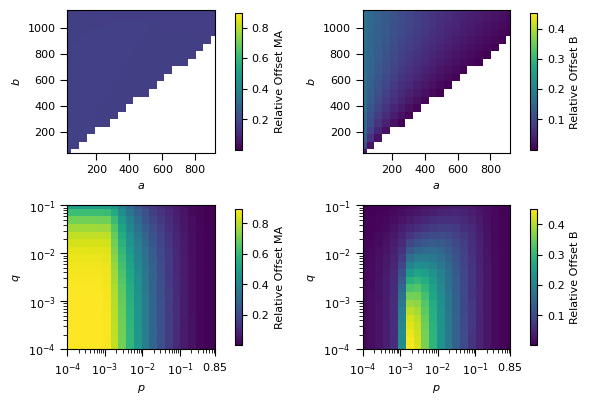

In [ ]:
# Figure settings
mm_to_in = 1/25.4
fig_w_mm = 150 # Total width
fig_h_mm = 100 # Total height
figsize_inch = (fig_w_mm * mm_to_in, fig_h_mm * mm_to_in)
plt.rcParams['font.size'] = 8

fig, axes = plt.subplots(2, 2, figsize=figsize_inch, constrained_layout=True)

# --- Common vmin/vmax for offset_MA across all relevant dataframes ---
all_ma_offsets = np.concatenate([
    df_ab_event3['offset_MA'].to_numpy(),
    df_pq_event3['offset_MA'].to_numpy()
])
vmin_ma, vmax_ma = np.nanmin(all_ma_offsets), np.nanmax(all_ma_offsets)

# --- Common vmin/vmax for offset_B across all relevant dataframes ---
all_b_offsets = np.concatenate([
    df_ab_event3['offset_B'].to_numpy(),
    df_pq_event3['offset_B'].to_numpy()
])
vmin_b, vmax_b = np.nanmin(all_b_offsets), np.nanmax(all_b_offsets)

# --- Top-Left: df_ab_event3, offset_MA (linear a, b) ---
ax00 = axes[0, 0]
m00 = heat(ax00, df_ab_event3, x='a', y='b', v='offset_MA', x_log_scale=False, y_log_scale=False, vmin=vmin_ma, vmax=vmax_ma)
cbar00 = fig.colorbar(m00, ax=ax00, shrink=0.95, label='Relative Offset MA')
ax00.set_xlim(df_ab_event3['a'].min(), df_ab_event3['a'].max())
ax00.set_ylim(df_ab_event3['b'].min(), df_ab_event3['b'].max())
ax00.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax00.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax00.set_xlabel(r'$a$')
ax00.set_ylabel(r'$b$')

# --- Top-Right: df_ab_event3, offset_B (linear a, b) ---
ax01 = axes[0, 1]
m01 = heat(ax01, df_ab_event3, x='a', y='b', v='offset_B', x_log_scale=False, y_log_scale=False, vmin=vmin_b, vmax=vmax_b)
cbar01 = fig.colorbar(m01, ax=ax01, shrink=0.95, label='Relative Offset B')
ax01.set_xlim(df_ab_event3['a'].min(), df_ab_event3['a'].max())
ax01.set_ylim(df_ab_event3['b'].min(), df_ab_event3['b'].max())
ax01.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax01.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax01.set_xlabel(r'$a$')
ax01.set_ylabel(r'$b$')

# --- Bottom-Left: df_pq_event3, offset_MA (log p, q) ---
ax10 = axes[1, 0]
m10 = heat(ax10, df_pq_event3, x='p', y='q', v='offset_MA', x_log_scale=True, y_log_scale=True, vmin=vmin_ma, vmax=vmax_ma)
cbar10 = fig.colorbar(m10, ax=ax10, shrink=0.95, label='Relative Offset MA')
ax10.set_xscale('log')
ax10.set_xlim(df_pq_event3['p'].min(), df_pq_event3['p'].max())
ax10.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 0.85])
ax10.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$0.85$'])
ax10.set_yscale('log')
ax10.set_ylim(df_pq_event3['q'].min(), df_pq_event3['q'].max())
ax10.set_xlabel(r'$p$')
ax10.set_ylabel(r'$q$')

# --- Bottom-Right: df_pq_event3, offset_B (log p, q) ---
ax11 = axes[1, 1]
m11 = heat(ax11, df_pq_event3, x='p', y='q', v='offset_B', x_log_scale=True, y_log_scale=True, vmin=vmin_b, vmax=vmax_b)
cbar11 = fig.colorbar(m11, ax=ax11, shrink=0.95, label='Relative Offset B')
ax11.set_xscale('log')
ax11.set_xlim(df_pq_event3['p'].min(), df_pq_event3['p'].max())
ax11.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 0.85])
ax11.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$0.85$'])
ax11.set_yscale('log')
ax11.set_ylim(df_pq_event3['q'].min(), df_pq_event3['q'].max())
ax11.set_xlabel(r'$p$')
ax11.set_ylabel(r'$q$')

plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/heatmaps_ab_pq.png', dpi=300)
plt.show()

In [ ]:
r_list = np.linspace(0.61, 9.19, 20).tolist()
p_list = [0.030]
q_list = [0.032]

df_r_event3 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_3)
df_r_event5 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_5)

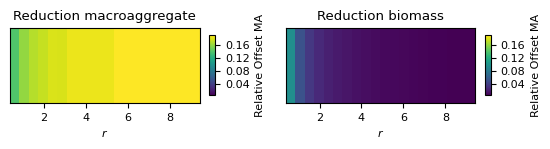

In [ ]:
def plot_1d_heatmap(ax, x_data, z_data, title, x_label, z_label, log_scale_x=False, cmap='viridis', vmin=None, vmax=None, x_ticks=None, x_ticklabels=None):
    # Sort data by x_data to ensure proper plotting with pcolormesh
    sort_idx = np.argsort(x_data)
    sorted_x_data = x_data[sort_idx]
    sorted_z_data = z_data[sort_idx]

    # Calculate bin edges for x-axis using the existing _edges function
    Xe = _edges(sorted_x_data)
    Ye = np.array([0, 1]) # Dummy y-axis for 1D heatmap

    # Reshape z_data for pcolormesh (needs to be 2D, e.g., (1, N) for a single strip)
    Z = np.array([sorted_z_data])

    if vmin is None:
        vmin = np.nanmin(Z)
    if vmax is None:
        vmax = np.nanmax(Z)

    m = ax.pcolormesh(Xe, Ye, np.ma.masked_invalid(Z),
                      shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_yticks([]) # Hide y-axis ticks as it's a dummy axis
    ax.set_ylabel('') # No y-axis label for the dummy axis

    if log_scale_x:
        ax.set_xscale("log")
        # Apply default log locators and formatters ONLY if custom ticks are not provided
        if x_ticks is None:
            ax.xaxis.set_major_locator(LogLocator(base=10))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
            ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
            ax.xaxis.set_minor_formatter(LogFormatterMathtext(base=10, labelOnlyBase=False))
    else:
        ax.set_xscale("linear")

    # Apply custom ticks if provided (after setting scale)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if x_ticklabels is not None:
        ax.set_xticklabels(x_ticklabels)
    # If custom ticks are provided for a log scale, ensure they are formatted nicely.
    # If labels are not explicitly provided, use LogFormatterMathtext for custom ticks as well.
    elif log_scale_x and x_ticks is not None and x_ticklabels is None:
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.xaxis.set_minor_formatter(LogFormatterMathtext(base=10, labelOnlyBase=False))

    return m

# Figure setting
mm_to_in = 1/25.4
fig_w_mm, fig_h_mm = 140, 35 # Adjusted height for single row
plt.rcParams["font.size"] = 8
# Set w_pad for constrained_layout before creating the figure
plt.rcParams['figure.constrained_layout.w_pad'] = 0.1 # Set w_pad to 0.1 for a slight horizontal gap

fig, axes = plt.subplots(
    1, 2, # Changed to 1 row, 2 columns
    figsize=(fig_w_mm*mm_to_in, fig_h_mm*mm_to_in),
    constrained_layout=True
)

# Common vmin/vmax for MA offsets across all relevant event dataframes
all_ma_offsets = np.concatenate([
    df_r_event3['offset_MA'].to_numpy(),
    df_r_event5['offset_MA'].to_numpy()
])
vmin_ma, vmax_ma = np.nanmin(all_ma_offsets), np.nanmax(all_ma_offsets)

# --- Plot (0,0): df_r_event3, offset_MA ---
ax0 = axes[0] # Access first subplot in the single row
m0 = plot_1d_heatmap(
    ax0,
    x_data=df_r_event3['r'].to_numpy(),
    z_data=df_r_event3['offset_MA'].to_numpy(),
    title='Reduction macroaggregate',
    x_label=r'$r$', # Added x-label for the single row
    z_label='Relative Offset MA',
    log_scale_x=False, # Changed to linear scale
    vmin=vmin_ma, vmax=vmax_ma
)
cb0 = fig.colorbar(m0, ax=ax0, shrink=0.8, aspect=10, label='Relative Offset MA')
cb0.locator = plt.MaxNLocator(nbins=5)
cb0.update_ticks()
# ax0.set_xlim(r_list[0], r_list[-1]) # Removed for linear scale
# ax0.tick_params(labelbottom=False) # Removed as x-labels are now desired

# --- Plot (0,1): df_r_event5, offset_MA ---
ax1 = axes[1] # Access second subplot in the single row
m1 = plot_1d_heatmap(
    ax1,
    x_data=df_r_event5['r'].to_numpy(),
    z_data=df_r_event5['offset_MA'].to_numpy(),
    title='Reduction biomass',
    x_label=r'$r$', # Added x-label for the single row
    z_label='Relative Offset MA',
    log_scale_x=False, # Changed to linear scale
    vmin=vmin_ma, vmax=vmax_ma
)
cb1 = fig.colorbar(m1, ax=ax1, shrink=0.8, aspect=10, label='Relative Offset MA')
cb1.locator = plt.MaxNLocator(nbins=5)
cb1.update_ticks()
# ax1.set_xlim(r_list[0], r_list[-1]) # Removed for linear scale
# ax1.tick_params(labelbottom=False) # Removed as x-labels are now desired

plt.savefig("/content/drive/MyDrive/Fractal Interaction/Save/fig/heatmaps_r_event3-5_ma.png", dpi=300)
plt.show()